In [2]:
"""
import modules
"""

from prepare_data import prepare_df_from_mac_5_year as prepare_CCL
from prepare_data import prepare_paths as prepare_paths
from emulate_reduction import emulator_v6 as emulate
from visualize_output import vis_emulator_v1 as v1_plot
from pym import pym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

dir(prepare_paths)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'colors',
 'combine_azure_ctax',
 'np',
 'os',
 'output_costs_timer',
 'pd',
 'plot_MAC',
 'plt',
 'prepare_data',
 'pym',
 'scale_ctax',
 'truncate_colormap',
 'world_MAC_data',
 'world_emulator_data']

In [3]:
"""
load data (cubic cubicroot linear and IAMC)
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
PATH_IAMC_MYM = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_mym/'
PATH_IAMC_CSV = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_csv/'

FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

In [74]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2100
region = 2
TIMERSTEP = 10
test_size = 0.2
stepsize_ctax_paths = 10
number_of_weights = 2

13977056010000.0
['2020' '2030' '2040' '2050' '2060' '2070' '2080' '2090' '2100']


,2020,2030,2040,2050,2060,2070,2080,2090,2100
2,0.00000,125.679743,559.583125,377.884249,614.983930,837.214605,1055.144405,1107.047074,1208.443638
3,16.79843,375.450790,744.035380,1079.914880,1789.922860,2234.489290,2638.756340,2886.560600,2993.445400
4,0.00000,0.000000,36.428481,59.338206,96.655752,157.441716,219.445254,266.388300,349.559658
5,13.00000,85.000000,188.000000,304.000000,490.000000,807.000000,1333.000000,2135.000000,3480.084000
6,0.00000,400.000000,50.000000,1300.000000,2500.000000,1000.000000,1100.000000,3000.000000,500.000000


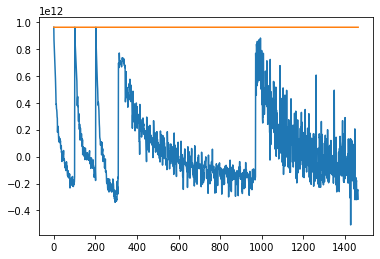

In [554]:
"""
load reductions calculated using the costcurvecooker

input: csv of all reductions (prepared using organize_azure_output.py)
        and definded ctax paths 
        
output: pandas dataframe with ctax paths and reductions until given year
"""

reload(prepare_paths)

# load reduction from azure output
emissions = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax.csv')
years = [1971, 1981, 1991, 2001, 2011, 2021, 2031, 2041, 2051, 2061, 2071, 2081, 2091, 2100]
columns = ['region', 'ctax_index'] + years  # dont know how to set headers for multi-index
emissions = emissions.iloc[:, 1:]
emissions.columns = columns

year_world = 2100

baseline = emissions.loc[emissions.ctax_index == 0]
world_baseline = emissions.loc[emissions.ctax_index == 0][year_world].sum()
print(world_baseline)

# load ctax paths csv
ctax_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/IAMC_paths/all_ctax_paths_test.xlsx', index_col=[0])
ctax_paths.index.name = 'ctax_index'

# functie met jaar en regio geeft dataframe met paths en reducties (%)
data_for_emulator = prepare_paths.combine_azure_ctax(year, region, ctax_paths, emissions, baseline)
data_for_emulator_world = prepare_paths.world_emulator_data(year_world, ctax_paths, emissions, world_baseline)

data_1 = pd.concat([data_for_emulator_world[:310], data_for_emulator_world[1449:1464]])  #only lin cubic and root
data_2 = data_for_emulator_world[311:970]  #only scaled IAMC
data_3 = data_for_emulator_world[971:1448]  #only random

# load costcheck dataframe
costcheck_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/test_paths_costs.xlsx',
                               index_col=0, header=0)

# prepare_paths.plot_MAC(data_for_emulator)
costcheck_paths.tail()

In [11]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_CCL)

lin_reduction = prepare_CCL.reduction_df(df_linear, year, region)
cubic_reduction = prepare_CCL.reduction_df(df_cubic, year, region)
root_reduction = prepare_CCL.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_CCL.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_CCL.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_CCL.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

print(combi.year)

combi.tail()

2090


,2020,2030,2040,2050,2060,2070,2080,2090,reduction
196,0.0,2049.211198,2581.844324,2955.473969,3252.920011,3504.101858,3723.663866,3920.0,128.2418
197,0.0,2059.666357,2595.016999,2970.552918,3269.516541,3521.979928,3742.662151,3940.0,128.2428
198,0.0,2070.121516,2608.189674,2985.631867,3286.113072,3539.857999,3761.660436,3960.0,128.2438
199,0.0,2080.576675,2621.362349,3000.710816,3302.709603,3557.736070,3780.658721,3980.0,128.2448
200,0.0,2091.031834,2634.535024,3015.789765,3319.306133,3575.614140,3799.657006,4000.0,128.2458


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v6.py:127: RuntimeWarning: divide by zero encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v6.py:127: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Anaconda3\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


weights dataframe: 
            0          1  ctax
0   0.000000   0.000000     0
1   0.000000   0.000000   200
2   3.270776 -14.196515   400
3  -0.720182 -11.218360   600
4   1.345322  -7.091032   800
5   3.404386 -13.125404  1000
6   1.514596 -10.579052  1200
7   3.644976 -14.614635  1400
8   4.058227 -18.002047  1600
9   3.142661 -13.447917  1800
10  3.049038 -13.643817  2000
11  3.941340 -12.619035  2200
12  0.981200 -10.426597  2400
13  1.312546  -9.723242  2600
14  1.063819 -12.493120  2800
15  4.505096 -17.511126  3000
16  0.424595  -9.489457  3200
17  5.026403 -19.285957  3400
18  1.717791 -14.934398  3600
19  1.007046 -12.701800  3800
20  0.100712  -7.814271  4000


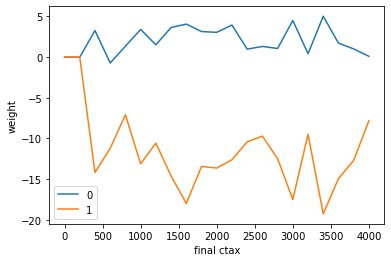

In [1113]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# x = emulate.CtaxRedEmulator(year, region, lin_paths, combi, ctax_paths, test_size)

x = emulate.CtaxRedEmulator(year, region, data_for_emulator_world[0:109], data_for_emulator_world, data_for_emulator_world, ctax_paths, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
pred = x.test_ctax_paths()
# x.scatter_and_mac(pred)



In [1108]:
reload(emulate)

x = emulate.CtaxRedEmulator(year, region, lin_paths, data_for_emulator_world, data_for_emulator_world, ctax_paths, test_size)

# multi linear regression model
# multi_lin_regr_mod = x.train_ctax_MLR()

# # polynomial regression model
# degree = 3
# poly_regr_mod = x.train_ctax_PR(degree)

# # # Ridge regression
# alpha = 1
# ridge_mod = x.train_ctax_ridge(alpha)

# # lasso regression
# alpha = 1
# lasso_mod = x.train_ctax_lasso(alpha)

# Regression tree
# max_depth = 5
# regr_tree = x.train_ctax_tree(max_depth)

# # Random forest
# regr_forest = x.train_ctax_forest(max_depth)

# # SVM
svm_regr = x.train_SVM()

# # MLPRegressor
# MLP_regr = x.train_MLPRegressor()

# TensorFlow
# TF_regr = x.train_TF()



Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    2.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished


SVM best params:  {'C': 100, 'gamma': 1e-06, 'kernel': 'rbf'}


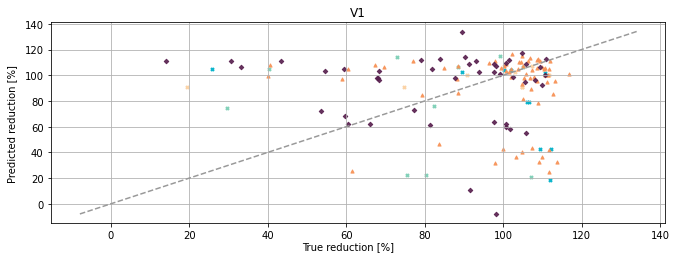

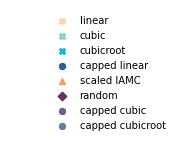

In [1114]:
"""
RMSE and R-squared dataframe
"""
score = x.score()
score.to_clipboard(excel=True)
x.pred_vs_true()

In [1110]:
emulated_costs = x.calc_miti_emu(costcheck_paths, world_baseline, 40)

,region,ctax_index,1971,1981,1991,2001,2011,2021,2031,2041,2051,2061,2071,2081,2091,2100
7960,23,294,2.194288e+11,2.598892e+11,3.013533e+11,3.214471e+11,3.299504e+11,3.062302e+11,1.820939e+11,3.008119e+10,-2.900653e+09,-2.196404e+10,-3.320372e+10,-2.908750e+10,-3.074307e+10,-2.674575e+10
7961,24,294,4.927703e+10,6.643270e+10,8.166405e+10,1.041427e+11,1.174053e+11,1.140099e+11,8.445837e+10,-1.598959e+10,-7.690326e+10,-8.236558e+10,-8.430151e+10,-7.343586e+10,-9.686820e+10,-7.048372e+10
7962,25,294,8.214564e+09,1.328791e+10,2.362342e+10,4.173473e+10,6.183535e+10,9.588086e+10,8.517248e+10,2.001246e+10,1.880047e+10,3.140029e+10,2.452479e+10,3.868656e+10,4.623081e+10,4.862689e+10
7963,26,294,5.482758e+09,6.218841e+09,9.572597e+09,1.082101e+10,1.643975e+10,2.249835e+10,2.123217e+10,-3.388712e+10,-7.835645e+10,-4.556693e+10,-3.455919e+10,-9.847621e+09,-6.547704e+10,-7.467104e+10
7964,27,294,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


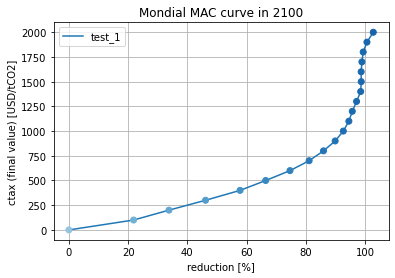

In [1111]:
"""
emulate miti costs and compare to TIMER == TRUE 
"""
reload(emulate)
reload(prepare_paths)

# load TIMER miticosts set
costcheck_timer = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax_costcheck.csv', index_col=0)
columns = ['region', 'ctax_index'] + years
costcheck_timer.columns = columns
ctax_paths_costcheck = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/test_paths_costs.xlsx', index_col=[0])
scaled_paths_costcheck = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/scaled_test_paths_costs.xlsx', index_col=[0])
ctax_paths_miti.index.name = 'ctax_index' 
# compare_miti = prepare_paths.combine_azure_ctax(year, region, ctax_paths_miti, miti_timer, baseline)
costcheck_world = prepare_paths.world_MAC_data(year, scaled_paths_costcheck, costcheck_timer, world_baseline)
costcheck_FAIR = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/costcheck_FAIR/costcheck_FAIR_tot.csv', index_col=[0])

prepare_paths.plot_MAC(costcheck_world[costcheck_world.which_path == 5].drop('which_path', axis=1), year, 'test_1', 'Blues')

costcheck_timer.tail()

                    1             2             3             4   \
Model                                                              
FAIR      7.940899e+12  7.940899e+12  7.940899e+12  7.940899e+12   
Emulated  3.434659e+12  5.347643e+12  5.677686e+12  6.230198e+12   
TIMER     5.580474e+12  5.852010e+12  6.328984e+12  6.212811e+12   

                    5             6             7             8   \
Model                                                              
FAIR      7.072416e+12  7.940899e+12  7.726151e+12  7.226925e+12   
Emulated  6.545988e+12  4.252574e+12  5.823777e+12  6.370733e+12   
TIMER     6.590932e+12  5.079751e+12  6.017646e+12  6.610990e+12   

                    9             10            11            12  
Model                                                             
FAIR      7.940899e+12  7.940899e+12  7.775927e+12  7.940899e+12  
Emulated  6.012055e+12  5.854814e+12  6.368396e+12  6.124005e+12  
TIMER     6.042604e+12  5.808581e+12  6.172678e+12

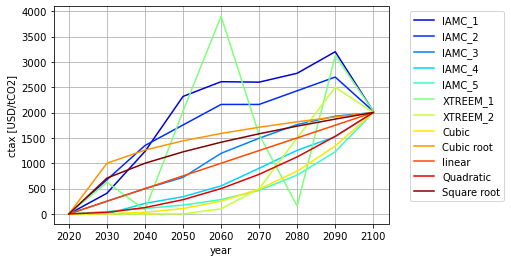

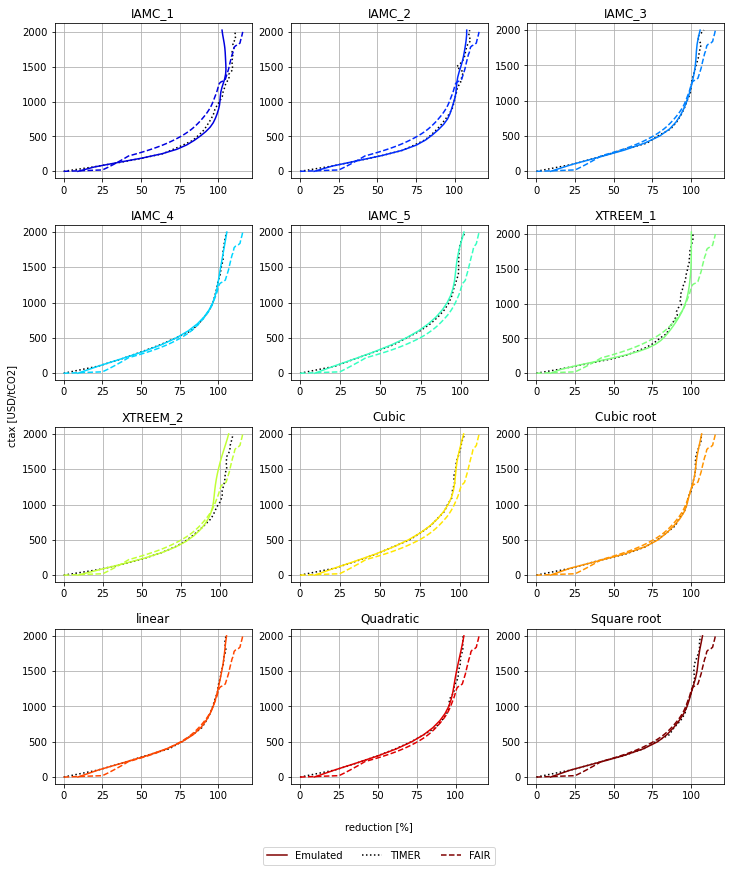

In [1112]:
costcheck_data = x.TIMER_vs_emu(ctax_paths_costcheck, costcheck_world, world_baseline, costcheck_FAIR)